# Using LSTM's to predict the future



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Import tqdm for progress bar
from tqdm import tqdm

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

## Define an LSTM based model
Below we define a simple network using one LSTM layer with 50 neurons and then a Dense layer to map to a single output. This network will be able to handle a sequence input and give back a single value sequence output (since there is one neuron in the Dense layer)

In [2]:
#Define
model=keras.models.Sequential()
model.add(keras.layers.Input(shape=(None,1)))
model.add(keras.layers.LSTM(20,return_sequences=False)) # LSTM layer with 50 neurons
model.add(keras.layers.Dense(1,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20)                  │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

## Define a function to model
Here we will pick a simple combination of sine function and an exponential. Then we will generate a sequence of x and y values.

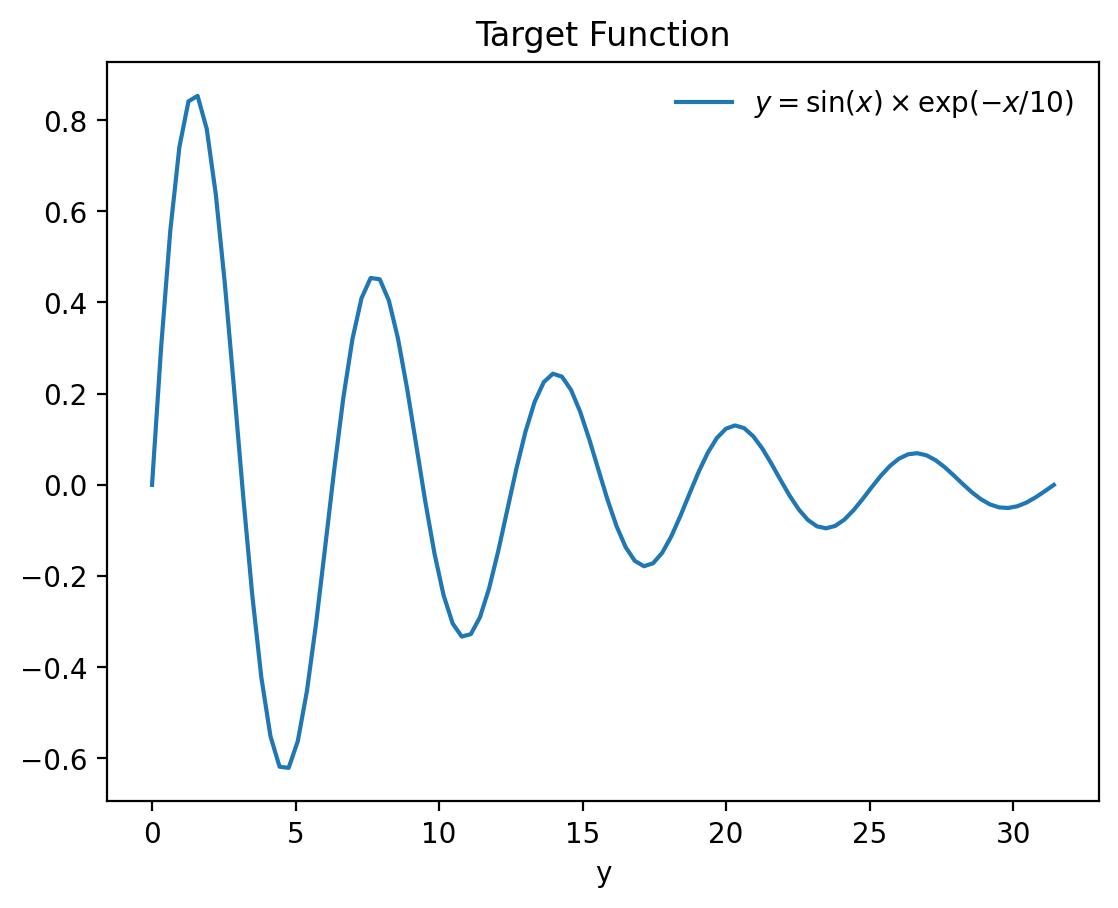

In [3]:
def sinexp(x):
    return np.sin(x)*np.exp(-x/10)

numPoints=100
x=np.linspace(0,10*np.pi,numPoints)
y=sinexp(x)
fig,ax=plt.subplots()
ax.plot(x,y,label=r"$y=\sin(x) \times \exp(-x/10)$")
ax.set_xlabel("x")
ax.set_xlabel("y")
ax.set_title("Target Function")
ax.legend()

## How to predict the future?
There are a number of ways we could try and train our LSTM to predict the future. Currently we have an array of $y$ data values. But how do we feed this into a model and use it to predict something. We need to define a few dimensions. How many steps do we want to include in the training data (window size) and how far into the future do we want to predict (offset)?


In [4]:
windowsize=10 #Number of samples we will use to train our network
offset=10 #How many samples into the future to predict



#This function splits up a 1-d array x into a series of overlapping windows
#The return is a tuple of the array of input windows and target (label) windows
def shapeArray(x,windowsize,offset):
    xInput= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize+offset)+1)])
    xLabel= np.array([x[i +windowsize : i+ windowsize+offset] for i in range(len(x)-(windowsize+offset)+1)])
    return (xInput,xLabel)

samp=np.arange(numPoints)  #Number of samples
sampInput,sampLabel=shapeArray(samp,windowsize,offset)
for i in range(5):
    print(i,sampInput[i],sampLabel[i])



#Get our xInput and xLabel arrays
xInput,xLabel=shapeArray(x,windowsize,offset)
#for i in range(5):
#    print(i,xInput[i],xLabel[i])

#Get our yInput and yLabel arrays
yInput=sinexp(xInput)
yLabel=sinexp(xLabel)

#Print show the shape of the arrays
print(yInput.shape)
print(yLabel.shape)

0 [0 1 2 3 4 5 6 7 8 9] [10 11 12 13 14 15 16 17 18 19]
1 [ 1  2  3  4  5  6  7  8  9 10] [11 12 13 14 15 16 17 18 19 20]
2 [ 2  3  4  5  6  7  8  9 10 11] [12 13 14 15 16 17 18 19 20 21]
3 [ 3  4  5  6  7  8  9 10 11 12] [13 14 15 16 17 18 19 20 21 22]
4 [ 4  5  6  7  8  9 10 11 12 13] [14 15 16 17 18 19 20 21 22 23]
(81, 10)
(81, 10)


So if we were to use the `samp` array we could train a network to predict `19` given the input `[0 1 2 3 4 5 6 7 8 9]` and `23` given `[ 4  5  6  7  8  9 10 11 12 13]`

## Training the network
Now we need to train our model. Again there are many ways we could choose to do this. Here we will pick a random starting $x_0$ and then generate 100 points from that starting position. So that each step of the training will use (slightly) different input and target values.

100%|██████████| 200/200 [00:04<00:00, 48.13it/s] 


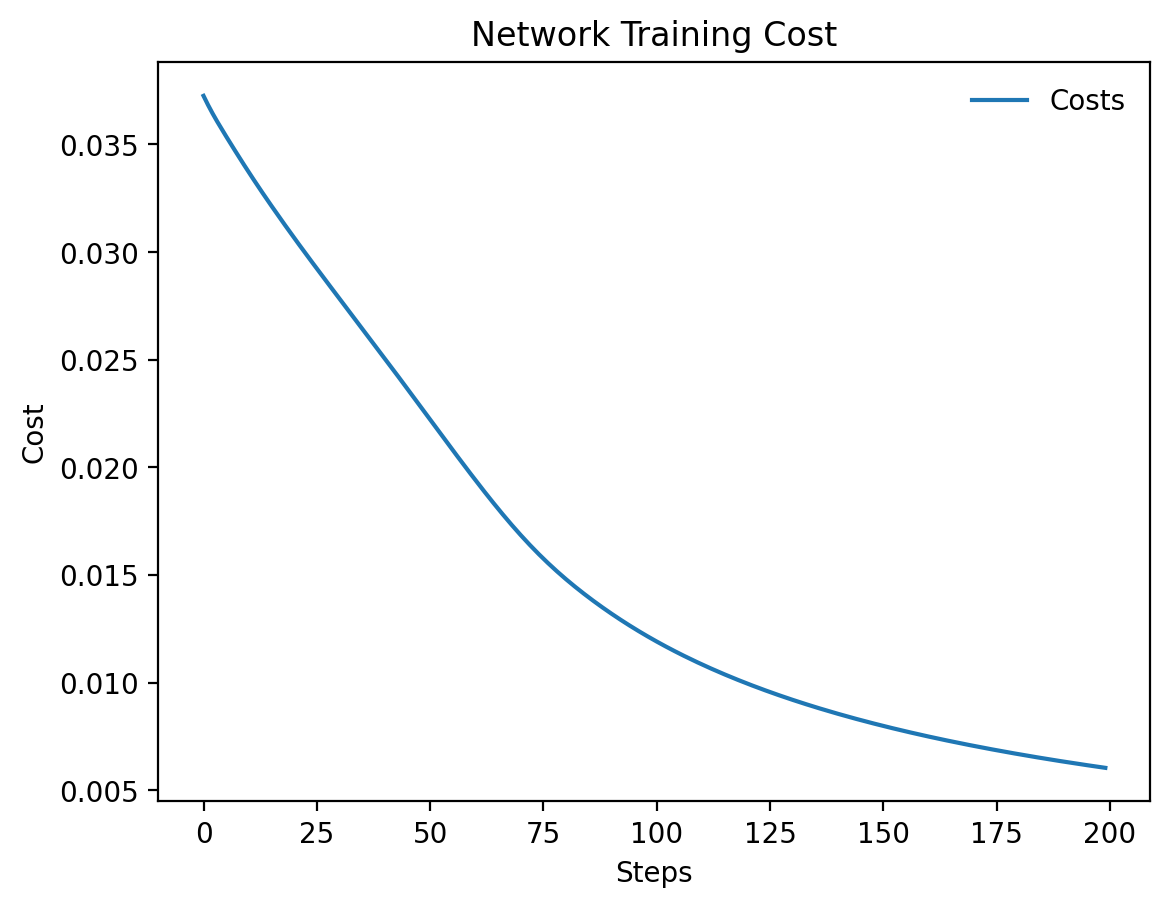

In [5]:
steps=200  #Number of training steps
costs=np.zeros(steps)  #Array for plotting cost
for i in tqdm(range(steps)):
    x0=0#np.random.uniform(low=0,high=5)  #Pick random start point between 0 and 5
    x=np.linspace(x0,x0+10*np.pi,numPoints) #generate numPoints points from that  posiiton
    xInput,xLabel=shapeArray(x,windowsize,offset)  #Split that into the input and label arrays

    yInput=sinexp(xInput)  # Apply the sinexp function to xInput
    yLabel=sinexp(xLabel)  # Apply the sinexp function to xLabel
    # Now we need to reshape the array into batchsize * window size * features (1)
    y_in=yInput.reshape(yInput.shape[0],yInput.shape[1],1)  # Reshape the input array to have the dimensions (batchsize,time samples, features)
    # We only want a single number for the target (since we set return_sequences=False above). We will take the last sample of the yLabel
    y_target=yLabel[:,-1].reshape(yLabel.shape[0],1) # Reshape the output array to have the dimensions (batchsize, time samples)
    costs[i]=model.train_on_batch(y_in,y_target) #Train the network

#Plot costs vs steps
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

## Network performance
So our network training gets a low cost but does this correspond to good predictive performance? Let's start by plotting the input and expected target.

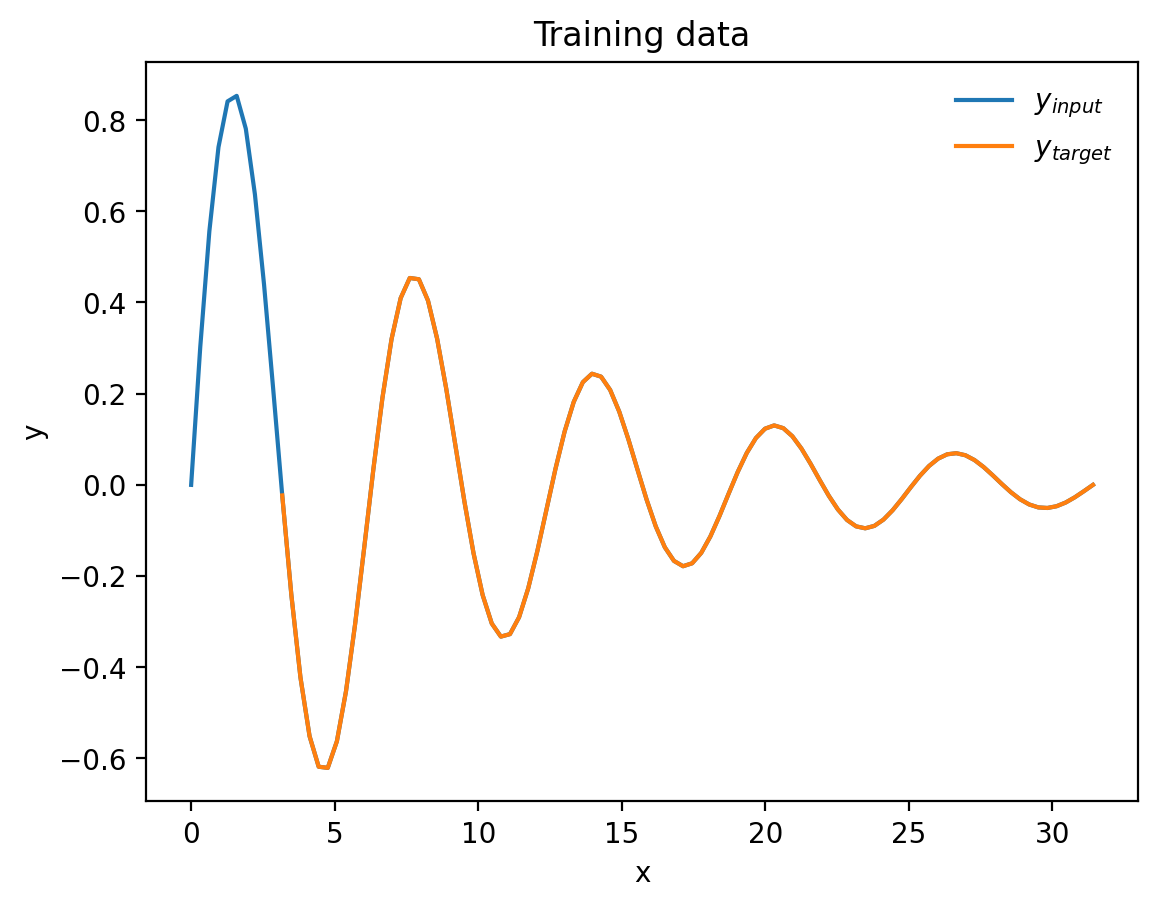

In [6]:
x_test=np.linspace(0,10*np.pi,numPoints)
y_test=sinexp(x_test)
y_testoff=sinexp(x_test[offset:])
fig,ax=plt.subplots()
samps=np.arange(0,numPoints-offset)
ax.plot(x_test,y_test,label=r"$y_{input}$")
ax.plot(x_test[offset:],y_testoff,label=r"$y_{target}$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Training data")
ax.legend()

## Looking at a single window of data
We feed in a window of `windowsize` samples and try to predict the value that comes `offset` values after this.

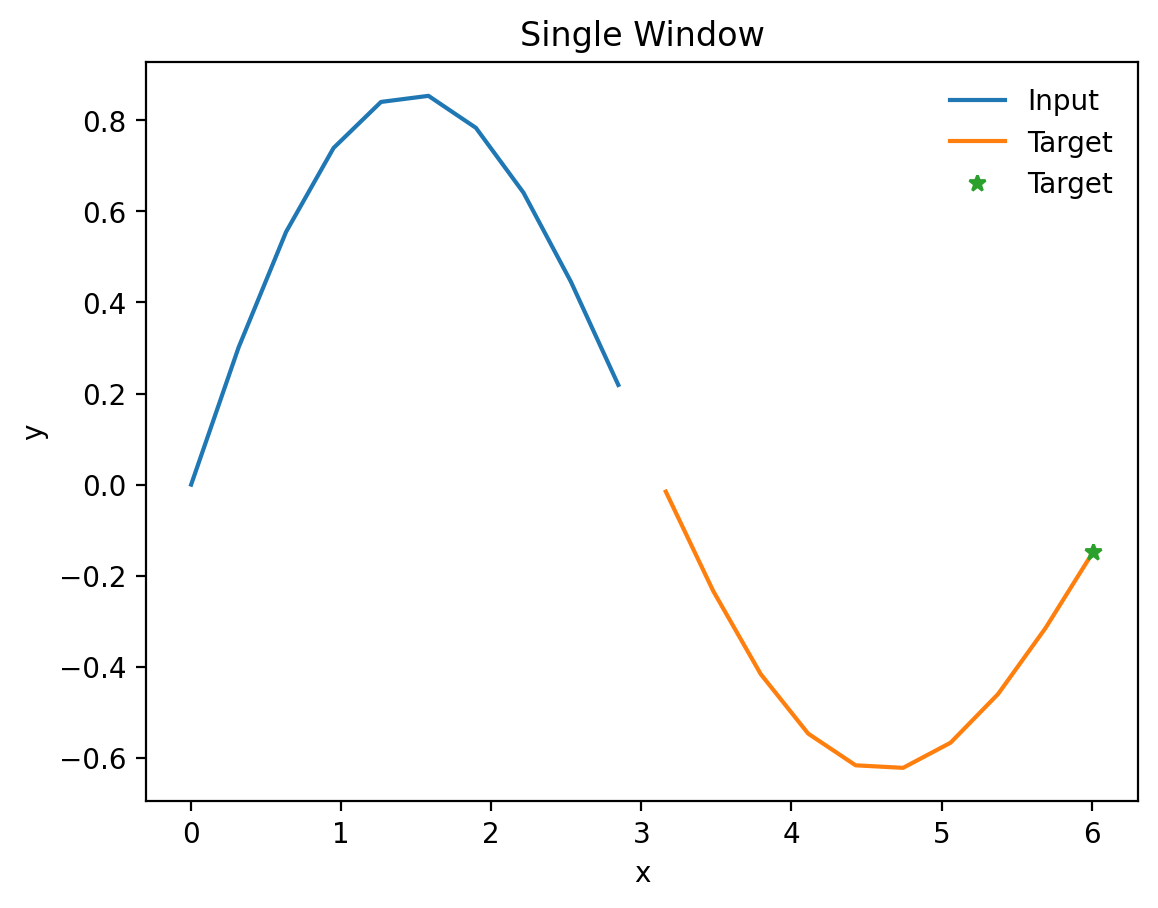

In [7]:
#Note that our network has been trained on a particular dx between samples if we don't use this it will not work well!
#Predict over a larger phase space from 0 ->15pi instead of 0->10pi
numTestPoints=150
x_test=np.linspace(0,15*np.pi,numTestPoints)
y_test=sinexp(x_test)
y_testoff=sinexp(x_test[offset:])
test_samps=np.arange(0,numTestPoints-offset)
xTest_in,xTest_label=shapeArray(x_test,windowsize,offset)
yTest_in=sinexp(xTest_in)
yTestLabel=sinexp(xTest_label)


fig,ax=plt.subplots()
ax.plot(xTest_in[0],yTest_in[0],label="Input")
ax.plot(xTest_label[0],yTestLabel[0],label="Target")
ax.plot(xTest_label[0][-1],yTestLabel[0][-1],"*",label="Target")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Single Window")
ax.legend()
#np.shape(yTest_in)



## The actual network prediction
Below we plot the actual prediction vs the expected function. As ever most of the challenege is wrestling the arrays into the correct format and organisation.

(131, 1)


(-3.0, 49.0)

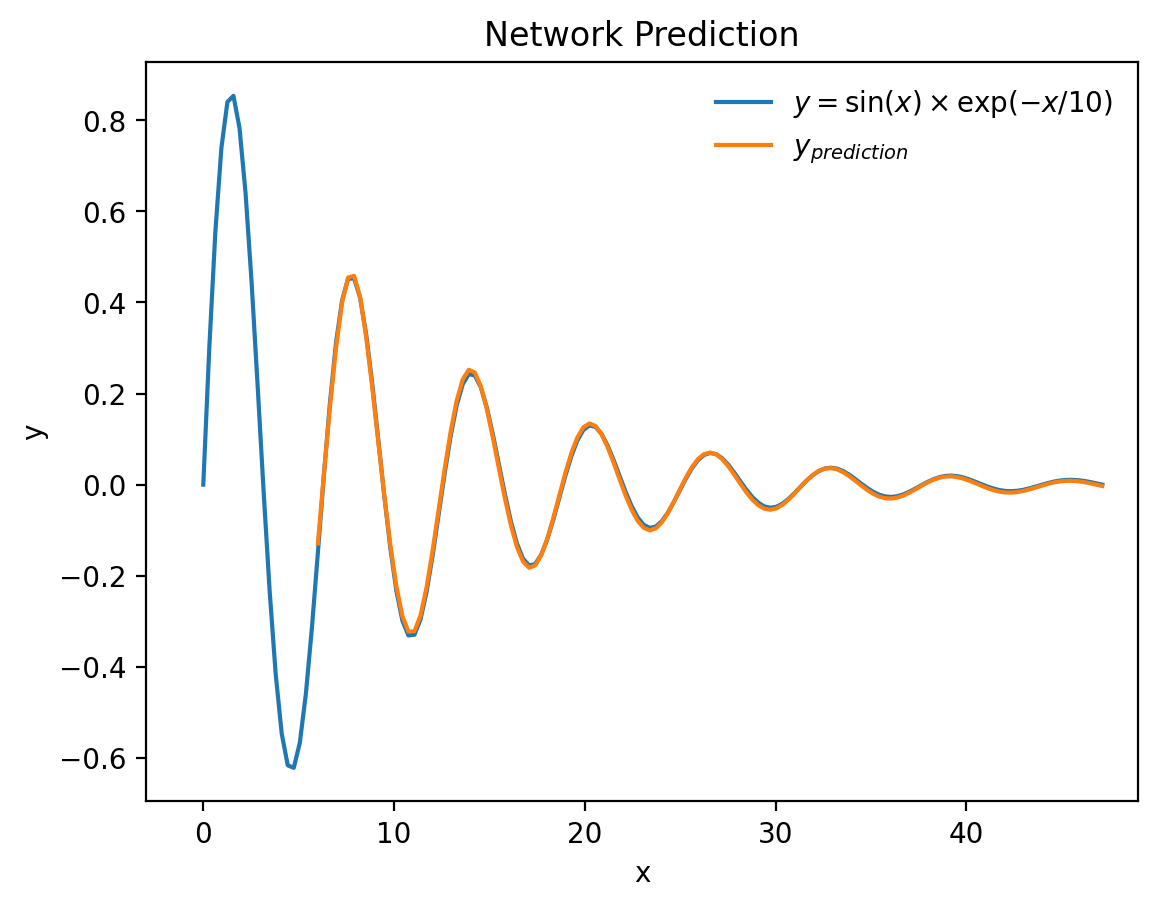

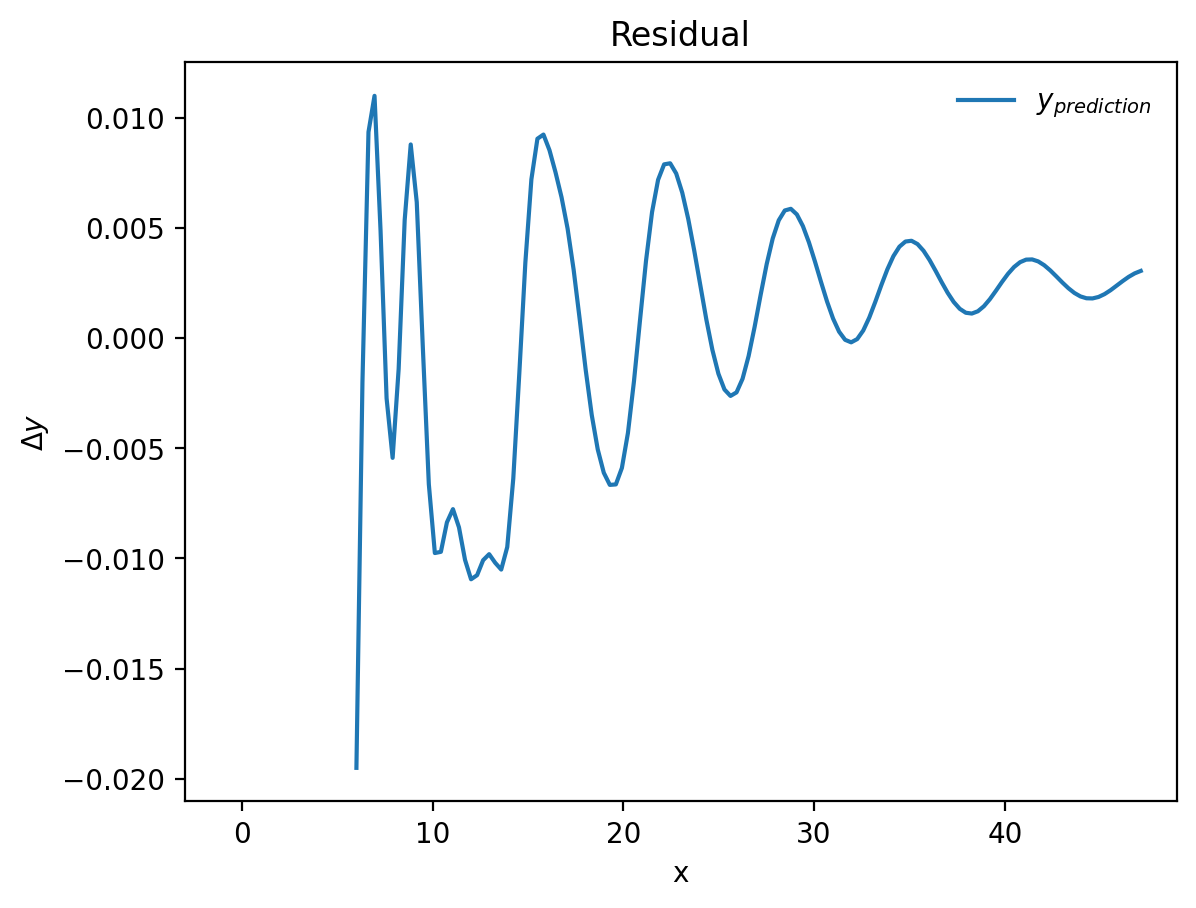

In [12]:

yTest_in2=yTest_in.reshape(yTest_in.shape[0],yTest_in.shape[1],1)
y_hat=model.predict_on_batch(yTest_in2.reshape(yTest_in2.shape[0],windowsize,1))
print(y_hat.shape)
fig,ax=plt.subplots()
ax.plot(x_test,y_test,label=r"$y=\sin(x) \times \exp(-x/10)$")
#ax.plot(x_test[offset:],y_testoff,label=r"$y_{target}$")
ax.plot(x_test[windowsize+offset-1:],y_hat.reshape(y_hat.shape[0]),label=r"$y_{prediction}$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Network Prediction")
ax.legend()
ax.set_xlim([-3,49])

fig,ax=plt.subplots()
#ax.plot(x_test[offset:],y_testoff,label=r"$y_{target}$")
ax.plot(x_test[windowsize+offset-1:],y_test[windowsize+offset-1:]-y_hat.reshape(y_hat.shape[0]),label=r"$y_{prediction}$")
ax.set_xlabel("x")
ax.set_ylabel(r"$\Delta y$")
ax.set_title("Residual")
ax.legend()
ax.set_xlim([-3,49])

## Suggested tasks


1.   Can you improve the prediction?
2.   Are there other functions which are more challenging to predict? (Maybe try multidimensional functions)
3.   How does the network complexity scale with function complexity

